## Theorem
Notice that in RNN, long steps will definitely lead to gradient vanish or explosion, so, GRU provide a latter support gating of the hidden state, which means whether a hidden state should be updated or reset.

## Reset Gate and Update gate
A reset gate allow us to control how much of the previous state we might still need to focus. An update gate allow us to control how much of the new state is just copy of the old state.

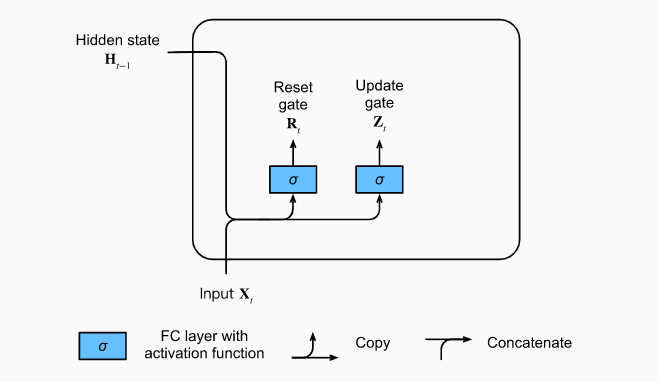

From the following graph, we can see that the hidden state of last time stamp $H_{t-1}$ and new input $X_t$ will passing two gates, where the formula is shown below:
1. $R_t = \sigma (X_tW_{xr} + H_{t-1}W_{hr} + b_r)$
2. $Z_t = \sigma (X_tW_{xz} + H_{t-1}W_{hz} + b_z)$

Same as RNN, in each gate GRU introduced two learnable weight matrix to update Reset gate and update gate in GRU correspondly. Also, $\sigma$ is sigmoid function here. The dimension is: $W_{xr},W_{xz} \in R^{d*h}, W_{hr}, W_{hz} \in R^{h*h}, X \in R^{n*d}, H_{t-1} \in R^{n*h}$

## Candidate Hidden State
Then, each hidden state is calculate by the following formula:

$H_t^c= tanh(X_tW_{xh} + (R_t * H_{t-1})W_{hh} + b_h)$, where  Wxh and Whh are two learnable weights and * means element-wise computation, Rt is the output of reset gate(passing sigmoid function)

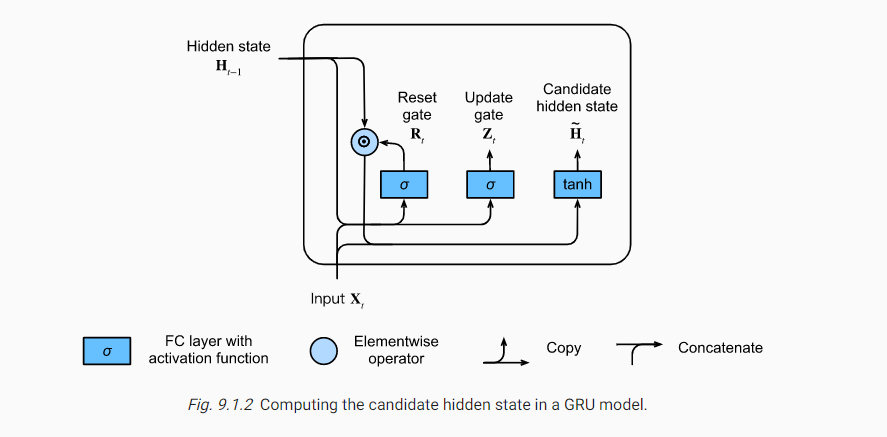

if R_t more close to 1, means this candidate hidden state should be focused, else the candidate hidden state will not affect this time step.

## Hidden State
Finally integrate the effect of update Gate $Z_t$. This operation means that to what extent the candidate hidden state $H_t^c$ and last hidden state $H_{t-1}$ will affect the next hidden state $H_t$

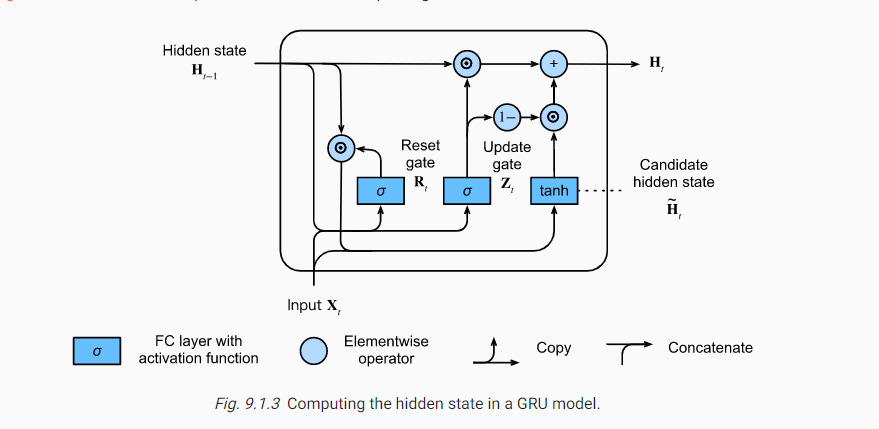

The formula is: $H_t = Z_t * H_{t-1} + (1 - Z_t) * H_t$, when z_t is close to 1, which means simply remains the last hidden state, which means the new input X_t will probably be ignored. Else, new hidden state will be approximate to candidate hidden state. These design will help us cope with the vanishing gradient problem in RNNS. 举个例子，如果从前往后update gate 都是1，则每一个时间步的输入都会被保留而且一只传入到结尾。

In conclusion:
1. GRU can better capture dependencies for sequences with large time step distance
2. Reset Gates capture short-term dependencies (help to create candidate hidden state)
3. Update Gates capture long-term dependencies (help to update the next hidden state by affecting last hidden state and candidate hidden state)

## Implementation


In [ ]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
import math
from torch.cuda import amp
from transformers import get_cosine_schedule_with_warmup
from collections import Counter
import collections

In [ ]:
class GRU_block(nn.Module):
    def __init__(self, vocab_size,embd_size,num_hiddens, bias = True, decoder = False):
        '''
        Same as Transformer and RNN, here I implement the embedding-based architecture
        '''
        super(GRU_block,self).__init__()
        self.embedding_matrix = nn.Embedding(vocab_size, embd_size)
        #Reset Gate parameter
        self.decoder = decoder
        self.num_hiddens = num_hiddens
        if not decoder:
            self.W_xr = nn.Linear(embd_size, num_hiddens)
            self.W_xz = nn.Linear(embd_size, num_hiddens)
            self.W_xh = nn.Linear(embd_size, num_hiddens)
        else:
            self.W_xr = nn.Linear(embd_size + num_hiddens, num_hiddens)
            self.W_xz = nn.Linear(embd_size + num_hiddens, num_hiddens)
            self.W_xh = nn.Linear(embd_size + num_hiddens, num_hiddens)
        self.W_hr = nn.Linear(num_hiddens, num_hiddens, bias = bias)
        self.act_reset = nn.Sigmoid()
        # Update Gate parameter
        
        self.W_hz = nn.Linear(num_hiddens, num_hiddens, bias = bias)
        self.act_update = nn.Sigmoid()
        # update candidate hidden state parameter
       
        self.W_hh = nn.Linear(num_hiddens, num_hiddens, bias = bias)
        self.act_hidden = nn.Tanh()
        # output layer parameters
        self.W_hq = nn.Linear(num_hiddens, vocab_size, bias= bias)
    def init_state(self,bs, num_hiddens, device):
        return torch.zeros((bs, num_hiddens), device = device)
    
    def forward(self, input_, state):
        # the input should be a 2D tensor shape as (bs, max_len)
        # by multiplying embedding matrix, the shape will be (bs, max_len, embd_size)
        if not self.decoder:
            input_ = self.embedding_matrix(input_)
        else:
            # if represent as decoder, concat the result
            context = state.repeat(input_.shape[1],1,1).permute(1,0,2)
            input_ = torch.cat((self.embedding_matrix(input_), context),2)
            #print(input_.shape)
        # for loop on time stamp dimension
        outputs = []
        state_ls = []
        for i in input_.permute(1,0,2):
            # each i shape is (bs, embd_size)
            # calculate update gate and reset gate
            Z = self.act_update(self.W_xz(i) + self.W_hz(state))
            R = self.act_reset(self.W_xr(i) + self.W_hr(state))
            H_candidate = self.act_hidden(self.W_xh(i) + self.W_hh(R * state))
            # update state
            state = Z * state + (1 - Z) * H_candidate
            output = self.W_hq(state)
            outputs.append(output.unsqueeze(1))
            state_ls.append(state)
        return torch.cat(outputs, dim = 1), state_ls[-1]

In [ ]:
# Test layer
x = torch.ones((2,6), dtype = torch.long)
gru = GRU_block(200, 100,24)
init = gru.init_state(2, 24, torch.device("cpu"))
output_ls, state_ls = gru(x, init)
output_ls.shape, state_ls.shape

## Apply on machine translation

In [ ]:
def clip_grad(net, theta):
    params = [p for p in net.parameters() if p.requires_grad and p.grad is not None]
    #[print(p.grad) for p in params]
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for para in params:
            para.grad[:] *= theta/norm
            
# basic processing code
class Build_vocabulary(object):
    '''
    Here we need to bulid a vocabulary for mapping
    '''
    def __init__(self, tokens = None, min_freq = 0, special_tokens = None):
        if tokens is None:
            tokens = []
        if special_tokens is None:
            special_tokens = []
        tokens = [token for line in tokens for token in line]
        counter = Counter(tokens)
        # sort by frequency
        self.freq = sorted(counter.items(), key = lambda x: x[1], reverse=True)
        # set special token
        self.idx_to_token = ["<unk>"] + special_tokens
        self.token_to_id = {token: ids for ids, token in enumerate(self.idx_to_token)}
        for token, freq in self.freq:
            if freq < min_freq:
                break
            if token not in self.token_to_id:
                self.idx_to_token.append(token)
                self.token_to_id[token] = len(self.idx_to_token) - 1
                
    #build some internal property
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        '''
        Return the token:ids for each input token in dict
        '''
        if not isinstance(token, (list, tuple)):
            return self.token_to_id.get(token, 0)
        return [self.__getitem__(token_) for token_ in token]
    
    def indices_to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def read_dataset():
    with open("./fra-eng/fra.txt", "r", encoding="utf-8") as f:
        text = f.read()
        text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != " "
    out = []
    for i, char in enumerate(text):
        if i>0 and no_space(char, text[i-1]):
            out.append(' '+char)
        else:
            out.append(char)
    text = "".join(out)
    # Tokenization
    english_word, french_word = [], []
    for i, sentence in enumerate(text.split("\n")):
        # split by \t
        result = sentence.split("\t")
        if len(result) == 2:
            english_word.append(result[0].split(" "))
            french_word.append(result[1].split(" "))
    return english_word, french_word

def padding_truncation(tokens, max_lens, padding_token):
    if len(tokens) > max_lens:
        return tokens[:max_lens]
    return tokens + [padding_token]*(max_lens - len(tokens))

def build_array(tokens, dic, max_length):
    '''
    This function build the array of each token
    '''
    tokens_mapping = [dic[token] for token in tokens]
    tokens_mapping = [token + [dic["<eos>"]] for token in tokens_mapping]
    # add padding, truncation
    tensor = torch.tensor([padding_truncation(token, max_length, dic["<pad>"]) for token in tokens_mapping])
    valid_len = (tensor != dic["<pad>"]).type(torch.int32).sum(1)
    return tensor, valid_len

def processing_french_english_dataset(batch_size, max_length):
    english_word, french_word = read_dataset()
    english_mapping = Build_vocabulary(english_word, min_freq=2, 
                                   special_tokens=["<pad>", "<bos>", "<eos>"])
    french_mapping = Build_vocabulary(french_word, min_freq=2, 
                                   special_tokens=["<pad>", "<bos>", "<eos>"])
    english_array, english_valid_len = build_array(english_word, english_mapping, max_length)
    french_array, french_valid_len = build_array(french_word, french_mapping, max_length)
    dataset = torch.utils.data.TensorDataset(*(english_array, english_valid_len, french_array, french_valid_len))
    data_iter = torch.utils.data.DataLoader(dataset,batch_size = batch_size, shuffle = True)
    return data_iter, english_mapping, french_mapping

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        #print(pred.shape, label.shape, valid_len.shape)
        weights = torch.ones_like(label)
        max_len = weights.size(1)
        mask = torch.arange((max_len), dtype = torch.float32,
                           device = weights.device)[None,:] < valid_len[:,None]
        weights[~mask] = 0
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
class GRU_decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, bias = True):
        super(GRU_decoder,self).__init__()
        self.rnn = GRU_block(vocab_size, embed_size, num_hiddens, bias=bias,decoder=True)
    
    def init_state(self, encoder_output):
        return encoder_output
    
    def forward(self, input_, state):
        output_ls, final_hidden_state = self.rnn(input_, state)
        return output_ls, final_hidden_state

In [ ]:
class GRU_seq2seq(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(GRU_seq2seq, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, encoder_input, decoder_input, device):
        init_state = self.encoder.init_state(encoder_input.shape[0],self.encoder.num_hiddens,device)
        encoder_output, encoder_hidden = self.encoder(encoder_input, init_state)
        decoder_state = self.decoder.init_state(encoder_hidden)
        return self.decoder(decoder_input, decoder_state)

In [ ]:
# set parameters, here i just use 1-layer (instead stacked layer to test the result)
num_hiddens,bs, num_step= 64,128,10
lr, num_epochs, device = 2e-4, 200, torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_iter, english_mapping, french_mapping =processing_french_english_dataset(bs,num_step)
rnn_encoder = GRU_block(len(english_mapping), num_hiddens, num_hiddens)
rnn_decoder = GRU_decoder(len(french_mapping), num_hiddens, num_hiddens)
RNN_s2s = GRU_seq2seq(rnn_encoder, rnn_decoder)
criterion = MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(RNN_s2s.parameters(), lr = lr)
scheduler = get_cosine_schedule_with_warmup(optimizer= optimizer, num_warmup_steps = 0, 
                                                num_training_steps= len(train_iter), num_cycles = 0.5)
num_gpu = 1
max_grad_norm = 1000

In [ ]:
def train(net, train_iter,criterion, optimizer, epochs, scheduler, gradient_accumulate_step, max_grad_norm ,num_gpu,
        target_vocab):
    net.train()   
    # instantiate a scalar object 
    ls          = []
    #device_ids  = [try_gpu(i) for i in range(num_gpu)]
    device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("\ntrain on %s\n"%str(device))
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
    net.apply(xavier_init_weights)
    net.to(device)
    for epoch in range(epochs):
        net.train()
        for idx, value in enumerate(train_iter):
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in value]
            # when forward process, use amp
            bos = torch.tensor([target_vocab["<bos>"]]*Y.shape[0], device = device).reshape(-1,1)
            # this called teacher forcing
            decoder_input = torch.cat([bos, Y[:,:-1]], 1)
            output,_ = net(X, decoder_input,device)
            # calculate masked loss
            loss        = criterion(output, Y, Y_valid_len)
            # prevent gradient to 0
            if gradient_accumulate_step > 1:
                # 如果显存不足，通过 gradient_accumulate 来解决
                loss    = loss/gradient_accumulate_step

            loss.sum().backward()
            # do the gradient clip
            gradient_norm = nn.utils.clip_grad_norm_(net.parameters(),max_grad_norm)
            #if idx > 0:
            clip_grad(net, 1)
            if (idx + 1) % gradient_accumulate_step == 0:
                # 多少 step 更新一次梯度
                optimizer.step()
                scheduler.step()
                #print("done 1 train")
            # 每1000次计算 print 出一次loss
            if idx % 30 == 0 or idx == len(train_iter) -1:
                with torch.no_grad():
                    print("==============Epochs "+ str(epoch) + " ======================")
                    print("loss: " + str(loss.mean()) + "; grad_norm: " + str(gradient_norm))
                    ls.append(loss.mean().item())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'loss': ls
                },"./checkpoint.params")

In [ ]:
train(RNN_s2s, train_iter, criterion,optimizer, num_epochs, scheduler,1,max_grad_norm,
     num_gpu,french_mapping)